<a href="https://colab.research.google.com/github/mschristophers/ComputerStereoVision/blob/main/OrchardRoboticsChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

In [ ]:
pip install open3d

In [ ]:
# Import libraries
import cv2 as cv
import numpy as np
import glob
import math
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import open3d as o3d

In [ ]:
# Upload files/pictures
from google.colab import files
files.upload()

Saving 1657826159881-0-UD.jpeg to 1657826159881-0-UD.jpeg
Saving 1657826159881-1-UD.jpeg to 1657826159881-1-UD.jpeg
Saving 1657826159964-0-UD.jpeg to 1657826159964-0-UD.jpeg
Saving 1657826159964-1-UD.jpeg to 1657826159964-1-UD.jpeg


#### Placing into Arrays

In [ ]:
# Put pairs into a 2D array of twins
files = glob.glob("/content/*.*")
files.sort()
numImages = len(files)

arr = []

for i in range(0, numImages, 2):
  twoDArray = np.empty((0, numImages // 2))

  if(files[i].endswith('0-DEPTH.jpeg')):
    continue

  else:
    arr.append([files[i], files[i+1]])

twoDArray = np.array(arr)

#### Creating Depth Maps

In [ ]:
# # Changes the images' metadata (when necessary); very slow
# def preprocessing(img):
#   alpha = 1.0
#   beta = 0
#   processed_img = np.zeros(img.shape, img.dtype)

#   # Formula: g(x,y) = alpha * f(x,y) + beta
#   for x in range(img.shape[0]):
#     for y in range(img.shape[1]):
#       processed_img[x,y] = np.clip(alpha * img[x,y] + beta, 0, 255)

#   return processed_img

In [ ]:
# Computes the stereo disparities with the StereoBM library (block matching algorithm),
# then converting them into depths
def stereoDepthMap(img1, img2):
  stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
  
  # Default variables arbitrarily set such that it produces the "best" output
  stereo.setPreFilterType(1)
  stereo.setPreFilterSize(5)
  stereo.setPreFilterCap(29)
  stereo.setMinDisparity(-30)
  stereo.setNumDisparities(160)
  stereo.setTextureThreshold(100)
  stereo.setUniquenessRatio(10)
  stereo.setSpeckleRange(14)
  stereo.setSpeckleWindowSize(100)

  disparity_map = stereo.compute(img1, img2)
  
  return disparity_map

In [ ]:
# Gets the "mean" of the disparity maps
def mean_disparity_maps(maps):
  disparity = np.zeros(maps[0].shape, 'uint8')
  for i in range(maps[0].shape[0]):
    for j in range(maps[0].shape[1]):
      disparity_ij = []
      for disparity_matrix in maps:
        disparity_ij.append(disparity_matrix[i, j])
      disparity[i, j] = sum(disparity_ij)/len(disparity_ij)
  return disparity

In [ ]:
def convert_to_visible(disparity, search_size):
  disparity = disparity.astype(np.float64) / search_size
  disparity = 255 * disparity
  disparity = disparity.astype(np.uint8)
  return disparity

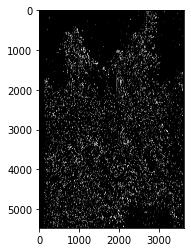

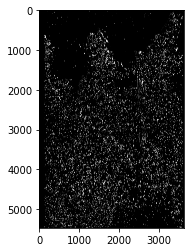

2
FINALMENTE


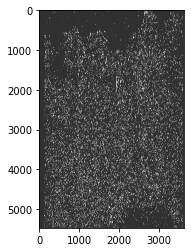

In [ ]:
disparity_maps = []

for row in twoDArray:
  img1 = mpimg.imread(row[0], 0)
  img2 = mpimg.imread(row[1], 0)

  # Converts image from RGB to gray
  img1_gray = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
  img2_gray = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)
  
  # processed_img1, processed_img2 = preprocessing(img1), preprocessing(img2) 

  disparity_map = stereoDepthMap(img1_gray, img2_gray)

  plt.imshow(disparity_map, cmap='Greys_r')
  plt.show()

  disparity_maps.append(disparity_map)

SEARCH_SIZE = 100

print(len(disparity_maps))
final_disparity_map = mean_disparity_maps(disparity_maps)
visible_disparity_map = convert_to_visible(final_disparity_map, SEARCH_SIZE)

plt.imshow(visible_disparity_map, cmap='Greys_r')
plt.show()

In [ ]:
# Disparity is inversely proportional to depth
def disparity_to_depth_map(disparity_map):
  disparity_map = disparity_map.astype(np.float64)
  depth_map = 1 / disparity_map
  depth_map = depth_map.astype(np.uint16)
  return depth_map

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


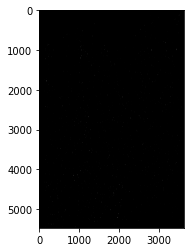

In [ ]:
# Gets the depth map
depth_map = disparity_to_depth_map(final_disparity_map)

plt.imshow(depth_map, cmap='Greys_r')
plt.show()

#### Fusion of Depth Maps

In [ ]:
# Displays the depth map with 3D point clouds (Open3D)
def display_depth_map(depth_map, color_img, fx, fy, cx, cy, scale):
	shape = color_img.shape;
	h = shape[0]
	w = shape[1]
	
	img = o3d.geometry.Image(color_img.astype('uint8'))
	depth = o3d.geometry.Image(depth_map.astype('uint16'))

	rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(img, depth)

	o3d_pinhole = o3d.camera.PinholeCameraIntrinsic()
	o3d_pinhole.set_intrinsics(w, h, fx, fy, cx, cy)

	pcd_from_depth_map = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, o3d_pinhole)
	pcd_from_depth_map.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
	o3d.visualization.draw_geometries([pcd_from_depth_map])

In [ ]:
# Displays the depth map
colored_img = mpimg.imread(twoDArray[0][0], 0)
display_depth_map(depth_map, colored_img, fx = 5814.40964, fy = 5814.40964, cx = 1176.72776, cy = 1176.72776, scale = 9.88)

##### Needed around 5 hours in total
##### Highly doubt if the code above works in the first place :)